## Mapper Prime v0.4.x demo
In addition to the README, this demo is meant to allow you to easily copy-paste bits of code and get your stuff working. (It also doubles as an integration test.)

In principle, you should be able to drop in your own UMAP data and timestamps, and have everything work as expected.

For some explaination of parameters see the included README.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#Normal installed imports
import numpy as np
import pandas as pd
import datamapplot
import sys, os
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from vectorizers import NgramVectorizer
from hdbscan import HDBSCAN
# Import temporal-mapper
import temporalmapper as tm
import temporalmapper.utilities_ as tmutils
import temporalmapper.weighted_clustering as tmwc



### Data

In [4]:
data_folder = '../tests/data/'
coordinate_file = 'ai_arxiv_coordinates.npy' # The 2D reduced co-ordinates, can be None
vector_file = 'ai_arxiv_vectors.npy'  
timestamp_file = None # If None, you need to add a cell that pulls these from a dataframe or something. 
vectors = np.load(data_folder+vector_file)
y_data = PCA(n_components = 1).fit_transform(vectors)
N_data = np.size(y_data)
print("Loaded",N_data,"data points.")
if os.path.isfile(data_folder+coordinate_file):
    map_data = np.load(data_folder+coordinate_file)
else:
    map_data = UMAP(n_components=2, verbose=True).fit_transform(vectors)

if timestamp_file:
    timestamps = np.load(data_folder+timestamp_file)
else:
    print("Do not forget to add a cell and make an array of timestamps.")


Loaded 10000 data points.
Do not forget to add a cell and make an array of timestamps.


In [5]:
## Making Timestamps
arxiv_df = pd.read_feather(data_folder+'ai_arxiv_data.feather')
# Compute a time column T which is the number of days since Jan 01, 2018.
def date_to_T(date):
    d0 = pd.Timestamp('2018-01-01')
    delta = date-d0
    return delta.days

arxiv_df["date"] = pd.to_datetime(arxiv_df["created"])
arxiv_df["T"] = arxiv_df["date"].apply(
    lambda x: date_to_T(x)
)

timestamps = np.array(arxiv_df["T"].to_list())


In [6]:
## Removing duplicate papers 
_, unique_idx = np.unique(arxiv_df['title'], return_index=True)
## skim out some papers for runtime

map_data = map_data[unique_idx]
timestamps = timestamps[unique_idx]
y_data = y_data[unique_idx]
vectors = vectors[unique_idx]
N_data = np.size(y_data)

## sorting by time
sorted_indices = np.argsort(timestamps)
map_data = map_data[sorted_indices]
vectors = vectors[sorted_indices]
timestamps = timestamps[sorted_indices]


### Mapper
In theory, if everything works ok, you should be able to just run the following cells without modification.

In [7]:
clusterer = HDBSCAN()
N_checkpoints = 8
TG = tm.TemporalMapper(
    timestamps,
    map_data,
    clusterer,
    N_checkpoints = N_checkpoints,
    neighbours = 100,
    slice_method='time',
    rate_sensitivity=1,
    kernel=tmwc.gaussian,
    verbose=True
)
TG.build()

Computing k nearest neighbours...
Computing spatial density...
Clustering at each time slice...
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.
Clusterer does not accept sample weights. Falling back to unweighted clustering.


Converting clusters to vertices: 100%|██████████| 8/8 [00:00<00:00, 6949.97it/s]


396 vertices added.


Adding edges: 100%|██████████| 7/7 [00:00<00:00, 673.86it/s]

Populating node centroids, colours, sizes...
Computing cluster colours...


### Visualizations & Diagnostics
There are a handful of built-in visualization tools you can use to analyse the temporal graph.

#### Centroid Datamap
If your data is two dimensional, you can use a *centroid datamap* plot. The vertices are placed at the centroids of their corresponding clusters, and edges
are drawn with linewidth given by their weight. Colour is used to encode temporal information, and can be controlled by a keyword argument `node_colouring`.
If `node_colouring=='desaturate'` (default) then the hue is determined by position in semantic space, and clusters further in the past will be more desaturated.
If `node_colouring='override'` then the semantic information is discarded and more warm colours represent more recent clusters.

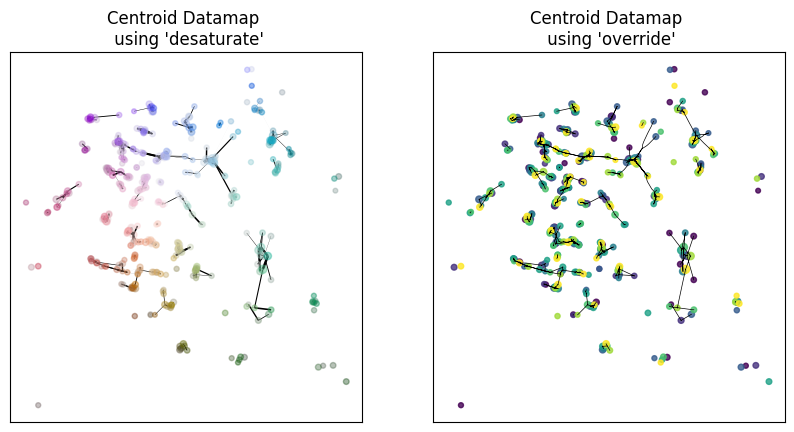

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
tmutils.centroid_datamap(TG, ax=ax1, node_colouring='desaturate', bundle=False)
ax1.set_title("Centroid Datamap \n using 'desaturate'")
tmutils.centroid_datamap(TG, ax=ax2, node_colouring='override')
ax2.set_title("Centroid Datamap \n using 'override'")
plt.show()

#### Time-Semantic Plot
If you can compute a 1d reduction of your data, then you can use it to plot a time-semantic graph. In this graph, the y-axis represents semantic distance and the
x-axis is time. The colour uses datamapplot palette handling, so if you plot this alongside a datamapplot the colours will match.

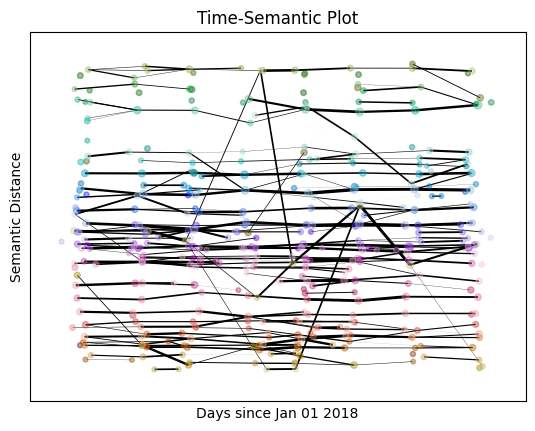

In [11]:
datamap_angle = np.arctan2(map_data[:,0], map_data[:,1])
ax=tmutils.time_semantic_plot(TG, datamap_angle)
ax.set_title("Time-Semantic Plot")
ax.set_ylabel("Semantic Distance")
ax.set_xlabel("Days since Jan 01 2018")

plt.show()

#### Sliceograph
The sliceograph is a visual representation of the open cover of your data's time function. The x-axis is time, and the black bars represent the intervals in the cover.

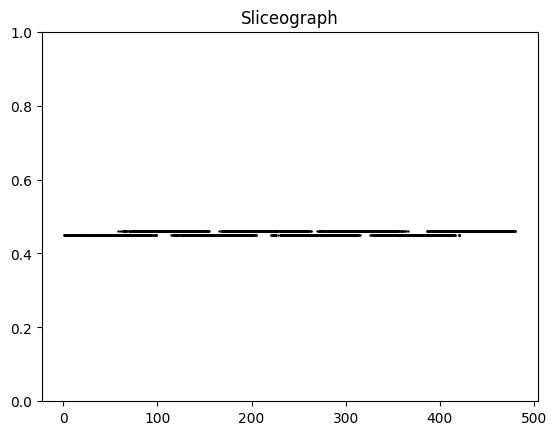

In [15]:
ax = tmutils.sliceograph(TG)
ax.set_title("Sliceograph")
plt.show()

#### Weighting & Clustering at each checkpoint
Here we plot the results of the clustering algorithm at each checkpoint. The alpha values represent the point's weight from the temporal kernel.

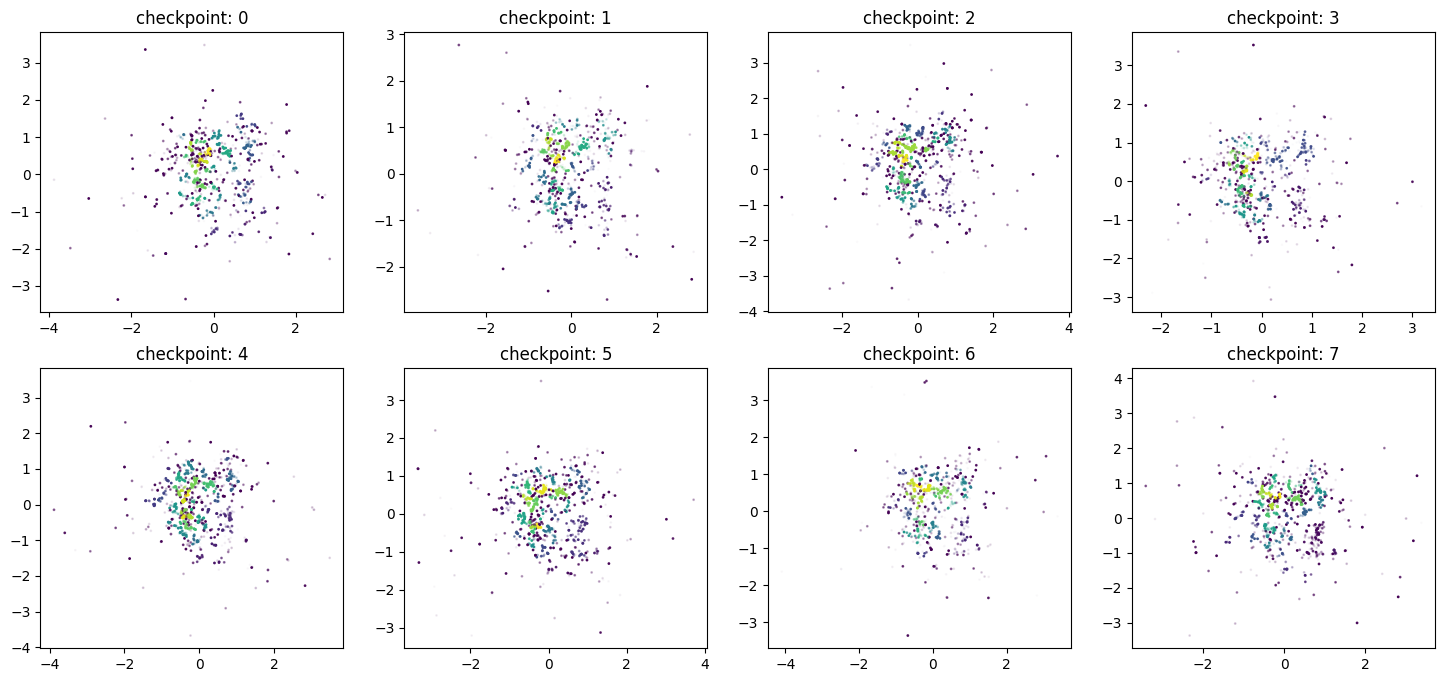

In [16]:
## Plotting what the clustering is at each checkpoint
weights = TG.weights
fig, axes = plt.subplots(2, N_checkpoints//2)
fig.set_figwidth(18)
fig.set_figheight(8)
axes = axes.reshape(N_checkpoints)
for k, slice_ in enumerate(TG.clusters):
    idx = (slice_ != -2).nonzero()[0]
    axes[k].set_title("checkpoint: "+str(k))
    axes[k].scatter(map_data[idx,0],map_data[idx,1],alpha=weights[k,idx],c=slice_[idx],s=1)
plt.show()